In [1]:
from __future__ import print_function

from scipy.stats import norm

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, Lambda
from keras.layers import Dropout
from keras.objectives import binary_crossentropy
import keras.backend as K
from keras import metrics

from keras.callbacks import TensorBoard, ModelCheckpoint
from time import time
import h5py

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# fijo la semilla aleatoria por reproducibilidad
np.random.seed(7)

C:\Users\roberto\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
data = pd.read_csv("D:/MBIT-2017-18-Master-Deep-Learning/ADNI-Alzheimer/ADNI_QT-PAD/ADNI_adnimerge_20170629_QT-freeze(modif2).csv",sep=';', encoding='latin-1')
data.head()

,RID,VISCODE,DX,DX.bl,EXAMDATE,CDRSB,ADAS13,MMSE,RAVLT.learning,FAQ,Hippocampus,Entorhinal,Fusiform,MidTemp,Age,Gender
0,2,bl,NL,CN,08/09/2005,0.0,18.67,28,4,0,8336,4177,16559,27936,74.3,0
1,2,m06,NL,CN,06/03/2006,0.0,19.67,28,3,0,8336,4177,16559,27936,74.8,0
2,2,m36,NL,CN,27/08/2008,0.0,20.00,29,2,0,8336,4177,16559,27936,77.3,0
3,2,m60,NL,CN,22/09/2010,0.0,23.00,28,5,0,8336,4177,16559,27936,79.3,0
4,2,m72,NL,CN,19/09/2011,0.0,21.00,23,3,0,8336,4177,16559,27936,80.3,0


In [3]:
RID                    = data['RID'].as_matrix()
Gender                 = data['Gender'].as_matrix()
Age                    = data['Age'].as_matrix()
CDRSB                  = data['CDRSB'].as_matrix()
ADAS13                 = data['ADAS13'].as_matrix()
MMSE                   = data['MMSE'].as_matrix()
RAVLT                  = data['RAVLT.learning'].as_matrix()
Hippocampus            = data['Hippocampus'].as_matrix()
Entorhinal             = data['Entorhinal'].as_matrix()
Fusiform               = data['Fusiform'].as_matrix()
MidTemp                = data['MidTemp'].as_matrix()

In [4]:
RID.shape

(8511,)

In [5]:
x_data = data.iloc[0:,[5,6,7,8,9,10,11,12,13,14,15]]
x_data.shape

(8511, 11)

In [6]:
x_data.head()

,CDRSB,ADAS13,MMSE,RAVLT.learning,FAQ,Hippocampus,Entorhinal,Fusiform,MidTemp,Age,Gender
0,0.0,18.67,28,4,0,8336,4177,16559,27936,74.3,0
1,0.0,19.67,28,3,0,8336,4177,16559,27936,74.8,0
2,0.0,20.00,29,2,0,8336,4177,16559,27936,77.3,0
3,0.0,23.00,28,5,0,8336,4177,16559,27936,79.3,0
4,0.0,21.00,23,3,0,8336,4177,16559,27936,80.3,0


In [7]:
x_train, x_test = train_test_split(x_data, test_size=0.25, random_state=42)
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
print(x_train.shape)  

(6383, 11)


In [8]:
original_dim = x_data.shape[1]
latent_dim = 2
intermediate_dim = 256
epsilon_std = 1.0

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# instantiate VAE model
vae = Model(x, x_decoded_mean)

# Compute VAE loss
xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 11)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          3072        input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

In [9]:
LOAD_MODEL = False
batch_size = 64
epochs = 500
filepath="autoencoder_vae_ADNI_best.h5" 

if not LOAD_MODEL:
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,
                                     save_best_only=True,
                                     mode='min') # graba sólo los que mejoran en validación
    
    callbacks_list = [checkpoint]
    
    vae.fit(x_train,
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            callbacks = callbacks_list,
            verbose=0,
            validation_data=(x_test, None))


Epoch 00001: val_loss improved from inf to -29.10550, saving model to autoencoder_vae_ADNI_best.h5

Epoch 00002: val_loss improved from -29.10550 to -45.76667, saving model to autoencoder_vae_ADNI_best.h5

Epoch 00003: val_loss improved from -45.76667 to -50.37675, saving model to autoencoder_vae_ADNI_best.h5

Epoch 00004: val_loss improved from -50.37675 to -52.50795, saving model to autoencoder_vae_ADNI_best.h5

Epoch 00005: val_loss improved from -52.50795 to -53.86608, saving model to autoencoder_vae_ADNI_best.h5

Epoch 00006: val_loss improved from -53.86608 to -55.06026, saving model to autoencoder_vae_ADNI_best.h5

Epoch 00007: val_loss improved from -55.06026 to -56.19308, saving model to autoencoder_vae_ADNI_best.h5

Epoch 00008: val_loss improved from -56.19308 to -56.71560, saving model to autoencoder_vae_ADNI_best.h5

Epoch 00009: val_loss improved from -56.71560 to -57.39762, saving model to autoencoder_vae_ADNI_best.h5

Epoch 00010: val_loss improved from -57.39762 to -5


Epoch 00105: val_loss did not improve from -64.24024

Epoch 00106: val_loss did not improve from -64.24024

Epoch 00107: val_loss did not improve from -64.24024

Epoch 00108: val_loss did not improve from -64.24024

Epoch 00109: val_loss did not improve from -64.24024

Epoch 00110: val_loss did not improve from -64.24024

Epoch 00111: val_loss did not improve from -64.24024

Epoch 00112: val_loss did not improve from -64.24024

Epoch 00113: val_loss did not improve from -64.24024

Epoch 00114: val_loss did not improve from -64.24024

Epoch 00115: val_loss did not improve from -64.24024

Epoch 00116: val_loss did not improve from -64.24024

Epoch 00117: val_loss did not improve from -64.24024

Epoch 00118: val_loss did not improve from -64.24024

Epoch 00119: val_loss did not improve from -64.24024

Epoch 00120: val_loss improved from -64.24024 to -64.28935, saving model to autoencoder_vae_ADNI_best.h5

Epoch 00121: val_loss did not improve from -64.28935

Epoch 00122: val_loss did not


Epoch 00250: val_loss improved from -65.01369 to -65.02661, saving model to autoencoder_vae_ADNI_best.h5

Epoch 00251: val_loss did not improve from -65.02661

Epoch 00252: val_loss did not improve from -65.02661

Epoch 00253: val_loss did not improve from -65.02661

Epoch 00254: val_loss improved from -65.02661 to -65.16609, saving model to autoencoder_vae_ADNI_best.h5

Epoch 00255: val_loss did not improve from -65.16609

Epoch 00256: val_loss did not improve from -65.16609

Epoch 00257: val_loss did not improve from -65.16609

Epoch 00258: val_loss did not improve from -65.16609

Epoch 00259: val_loss did not improve from -65.16609

Epoch 00260: val_loss did not improve from -65.16609

Epoch 00261: val_loss did not improve from -65.16609

Epoch 00262: val_loss did not improve from -65.16609

Epoch 00263: val_loss did not improve from -65.16609

Epoch 00264: val_loss did not improve from -65.16609

Epoch 00265: val_loss did not improve from -65.16609

Epoch 00266: val_loss did not i


Epoch 00397: val_loss did not improve from -65.35129

Epoch 00398: val_loss did not improve from -65.35129

Epoch 00399: val_loss did not improve from -65.35129

Epoch 00400: val_loss did not improve from -65.35129

Epoch 00401: val_loss did not improve from -65.35129

Epoch 00402: val_loss did not improve from -65.35129

Epoch 00403: val_loss did not improve from -65.35129

Epoch 00404: val_loss did not improve from -65.35129

Epoch 00405: val_loss did not improve from -65.35129

Epoch 00406: val_loss did not improve from -65.35129

Epoch 00407: val_loss did not improve from -65.35129

Epoch 00408: val_loss did not improve from -65.35129

Epoch 00409: val_loss did not improve from -65.35129

Epoch 00410: val_loss did not improve from -65.35129

Epoch 00411: val_loss did not improve from -65.35129

Epoch 00412: val_loss did not improve from -65.35129

Epoch 00413: val_loss did not improve from -65.35129

Epoch 00414: val_loss did not improve from -65.35129

Epoch 00415: val_loss did n

In [10]:
encoder = Model(x, z_mean)

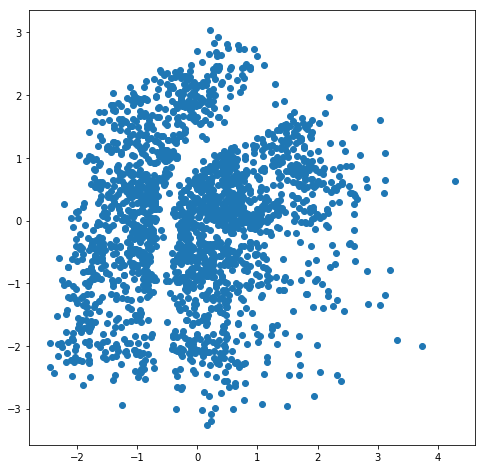

In [11]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(8, 8))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1])
plt.show()

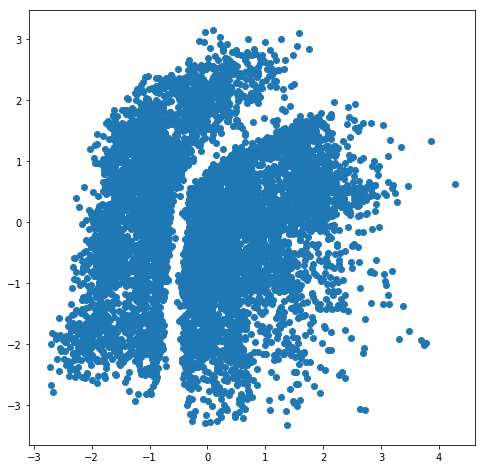

In [12]:
client = scaler.transform(x_data)
client_rep_latente = encoder.predict(client, batch_size=batch_size)
plt.figure(figsize=(8, 8))
plt.scatter(client_rep_latente[:, 0], client_rep_latente[:, 1])
plt.show()

In [13]:
print(data.shape)
print(client_rep_latente.shape)
print(client_rep_latente[0:5,])

(8511, 16)
(8511, 2)
[[1.7899821  0.65041   ]
 [1.946156   0.6041796 ]
 [2.0362554  0.51760036]
 [1.5071007  0.77083546]
 [1.6671463  0.3968914 ]]


In [14]:
data_client = np.hstack((data, client_rep_latente))
print(data_client.shape)

(8511, 18)


In [ ]:
from sklearn.cluster import KMeans

distorsions = []
for k in range(1, 30):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(client_rep_latente)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(1, 30), distorsions)
plt.grid(True)
plt.title('Elbow curve')

In [16]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(client_rep_latente)
num_cluster = (kmeans.labels_.reshape(client_rep_latente.shape[0],1)) + 1
print(num_cluster)

[[2]
 [2]
 [2]
 ...
 [4]
 [2]
 [2]]


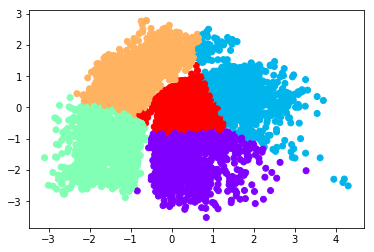

In [17]:
plt.scatter(client_rep_latente[:,0],client_rep_latente[:,1], c=kmeans.labels_, cmap='rainbow') 

In [18]:
data["cluster"] = num_cluster
data["latente-x"] = client_rep_latente[:,0]
data["latente-y"] = client_rep_latente[:,1]   

In [33]:
data.head() 

,RID,VISCODE,EXAMDATE,DX.bl,AGE.bl,PTGENDER,CDRSB,ADAS13,MMSE,RAVLT.learning,...,Fusiform,MidTemp,DX,Years.bl,Age,DX.num,Gender,cluster,latente-x,latente-y
0,2,bl,08/09/2005,CN,74.3,Male,0.0,18.67,28,4,...,16559,27936,NL,0.000000,74.300000,1,0,2,0.222270,-1.907894
1,3,bl,12/09/2005,AD,81.3,Male,4.5,31.00,20,1,...,15506,18422,Dementia,0.000000,81.300000,5,0,3,-1.313689,-0.031037
2,3,m06,13/03/2006,AD,81.3,Male,6.0,30.00,24,2,...,14400,16972,Dementia,0.498289,81.798289,5,0,3,-1.460631,0.347558
3,3,m12,12/09/2006,AD,81.3,Male,3.5,35.00,17,2,...,14617,17330,Dementia,0.999316,82.299316,5,0,3,-1.567803,0.217467
4,3,m24,12/09/2007,AD,81.3,Male,8.0,37.67,19,1,...,14033,16398,Dementia,1.998631,83.298631,5,0,3,-1.787708,0.234382


In [35]:
data.to_csv("D:/MBIT-2017-18-Master-Deep-Learning/ADNI-Alzheimer/ADNI_QT-PAD/cluster-ADNI-autoencoder-vae-5-cluster.csv",sep=';',decimal='.')
    